# Introduction

predict whether credit care clinet will default on their credit card


# Target 
 Default PMT (yes = 1, no=0)


# feature 

limit_bal: Amount of the given credit: it includes both the individual consumer credit and his/her family (supplementary) credit

sex: Gender (1 = male; 2 = female)

Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)

Marital status (1 = married; 2 = single; 3 = others)

Age (year)

History of past payment. (UCI) tracked the past monthly payment records as follows: The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above

Amount of bill statement


# import libraries 


In [5]:
# For data manipulation
import pandas as pd
import numpy as np


# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_formats = ['svg']
# sns.set(style='white', palette = 'Paired')

# Modeling
from sklearn.inspection import permutation_importance
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix,\
roc_auc_score, roc_curve, precision_recall_curve, fbeta_score, recall_score,\
precision_recall_fscore_support

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)
from sklearn.metrics import accuracy_score, make_scorer, log_loss

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


In [3]:
# Load the data
import pandas as pd
import numpy as np
from pathlib import Path
file_path = Path('UCI_Credit_Card (1).csv')
df = pd.read_csv(file_path,sep=';',index_col=0)
df.dropna()
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


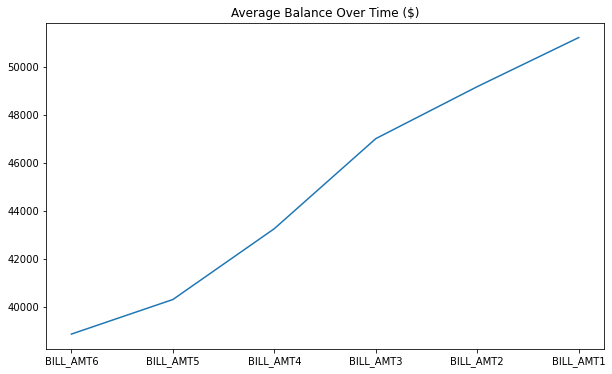

In [7]:
# Average balance over time
bal_months = ['BILL_AMT6', 'BILL_AMT5', 'BILL_AMT4',
              'BILL_AMT3', 'BILL_AMT2', 'BILL_AMT1']
avg_bal = []

for month in bal_months:
    avg_bal.append(df[month].mean())

plt.figure(figsize=(10,6))
plt.plot(bal_months, avg_bal)
plt.title('Average Balance Over Time ($)')
plt.show();

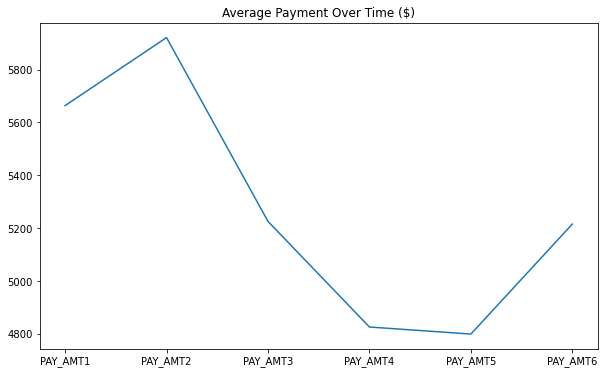

In [8]:
# Average payment over time
monthly_payments = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
avg_pmt = []

for month in monthly_payments:
    avg_pmt.append(df[month].mean())

plt.figure(figsize=(10,6))
plt.plot(monthly_payments, avg_pmt)
plt.title('Average Payment Over Time ($)')
plt.show();

/Users/kangdu/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


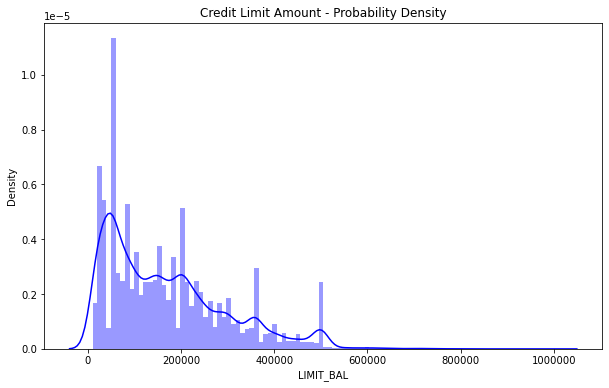

In [10]:
# Distribution of limit balance
plt.figure(figsize = (10,6))
plt.title('Credit Limit - Probability Density')
plt.ticklabel_format(style='plain', axis='x')
sns.distplot(df['LIMIT_BAL'],kde=True,bins=100, color="blue")
plt.show();

In [11]:
df['LIMIT_BAL'].value_counts()

50000.0      3365
20000.0      1976
30000.0      1610
80000.0      1567
200000.0     1528
             ... 
780000.0        2
690000.0        1
1000000.0       1
760000.0        1
327680.0        1
Name: LIMIT_BAL, Length: 81, dtype: int64

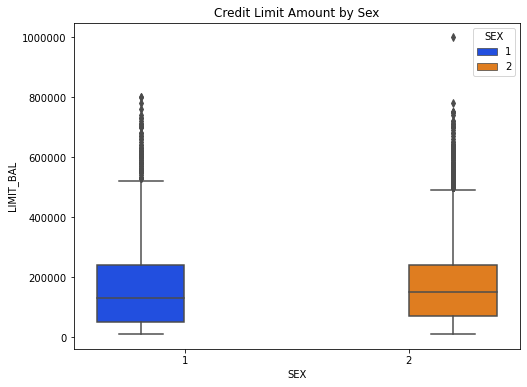

In [15]:
# Credit Limit vs Sex
plt.figure(figsize = (8,6))
plt.title('Credit Limit Amount by Sex')
plt.ticklabel_format(style='plain', axis='y')
sns.boxplot(x='SEX', y='LIMIT_BAL', hue='SEX', data=df, palette='bright')
plt.show();

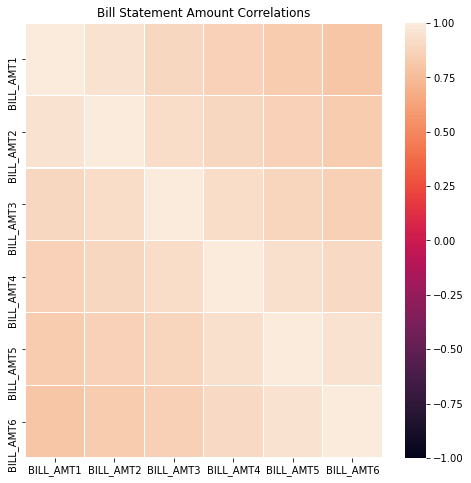

In [16]:
# Amount of Bill Statement
# Correlation Plot (BILL AMT AND HISTORY OF PASY PMT)
values = list({
        'BILL_AMT1':'Sep_Bal','BILL_AMT2':'Aug_Bal','BILL_AMT3':'Jul_Bal',
        'BILL_AMT4':'Jun_Bal','BILL_AMT5':'May_Bal','BILL_AMT6':'Apr_Bal'
    })

plt.figure(figsize=(8,8))
plt.title('Bill Statement Amount Correlations')
corr = df[values].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.1, vmin=-1, vmax=1)
plt.show();

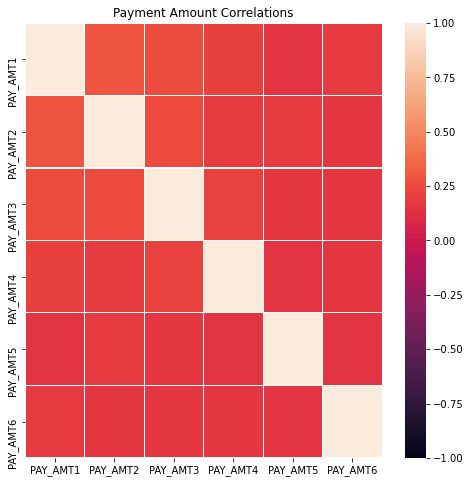

In [17]:

# Amount of Previous Payment
# Correlation Plot
values = monthly_payments

plt.figure(figsize=(8,8))
plt.title('Payment Amount Correlations')
corr = df[values].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.1, vmin=-1, vmax=1)
plt.show();

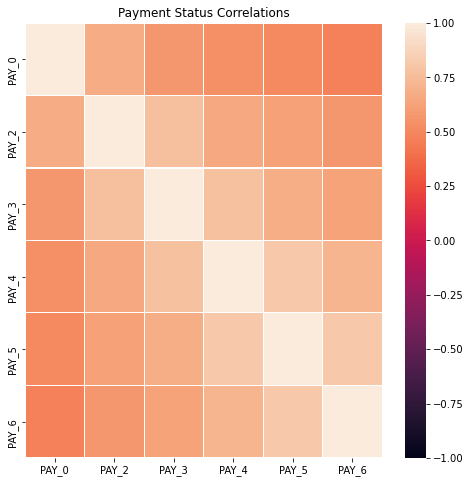

In [20]:
# Payment Status
# Correlation Plot
values = list(['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'])

plt.figure(figsize=(8,8))
plt.title('Payment Status Correlations')
corr = df[values].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=0.1, vmin=-1, vmax=1)
plt.show();

# Features and target 

In [22]:
X = df.copy()
X = X.drop('default.payment.next.month', axis= 1)
# Create our target
y = df["default.payment.next.month"]


In [25]:
X.dtypes

LIMIT_BAL    float64
SEX            int64
EDUCATION      int64
MARRIAGE       int64
AGE            int64
PAY_0          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
BILL_AMT1    float64
BILL_AMT2    float64
BILL_AMT3    float64
BILL_AMT4    float64
BILL_AMT5    float64
BILL_AMT6    float64
PAY_AMT1     float64
PAY_AMT2     float64
PAY_AMT3     float64
PAY_AMT4     float64
PAY_AMT5     float64
PAY_AMT6     float64
dtype: object

# encode Categoriacla variables such as sex, educaion and marriage

# split the data 


In [29]:
from sklearn.model_selection import train_test_split
def train_test_data_split(X,y):
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

    X, y = np.array(X), np.array(y)

    return X_train, X_val, X_test, y_train, y_val, y_test
    

In [31]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_data_split(X, y)

In [32]:
# sccale data 

def scale_data(X_train,X_val,X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled

In [33]:
X_train_scaled, X_val_scaled, X_test_scaled = scale_data(X_train, X_val, X_test)

In [55]:
def model_score(model_name, model, X_train_scaled, X_val_scaled,
                X_test_scaled, y_train, y_val, y_test, test=False):
   
    print('Calculating validation score...')

    my_model = model
    my_model.fit(X_train_scaled,y_train)
    print(f'{model_name} accuracy score: {my_model.score(X_val_scaled,y_val):.4}\n')

  
        
    return my_model

In [56]:
lr = model_score('LogReg', LogisticRegression(penalty='none'),
                       X_train_scaled,X_val_scaled, X_test_scaled,
                       y_train, y_val, y_test,test=False)

Calculating validation score...
LogReg accuracy score: 0.8148



In [57]:
visualization = LogisticRegression(penalty= 'none',random_state=0).fit(X_train_scaled,y_train)
visualization.predict_proba(X_val_scaled)


array([[0.86050258, 0.13949742],
       [0.58233122, 0.41766878],
       [0.78443815, 0.21556185],
       ...,
       [0.86058166, 0.13941834],
       [0.75070674, 0.24929326],
       [0.96448244, 0.03551756]])

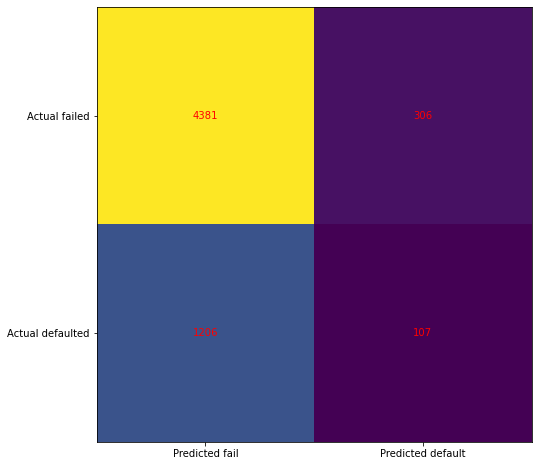

In [58]:
cm = confusion_matrix(y_test, visualization.predict(X_val_scaled))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted fail', 'Predicted default'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual failed', 'Actual defaulted'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='Red')
plt.show()

In [59]:
print(classification_report(y_test, visualization.predict(X_val_scaled)))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85      4687
           1       0.26      0.08      0.12      1313

    accuracy                           0.75      6000
   macro avg       0.52      0.51      0.49      6000
weighted avg       0.67      0.75      0.69      6000

